In [22]:
import os
import shutil
import time
import subprocess
import corner
import glob
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import numba as nb
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.cosmology import FlatLambdaCDM,Planck15
from astropy.convolution import convolve, convolve_fft, Moffat2DKernel, Gaussian2DKernel
import pandas as pd
from scipy import signal
import scipy.ndimage as ndimage
from scipy.signal import find_peaks
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import dblquad
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{bm}'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.dpi'] = 500
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
cosmo = Planck15
h = cosmo.H0.value/100

import matplotlib.ticker as mticker
import matplotlib as mpl
log_formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))
#from matplotlib.ticker import StrMethodFormatter, NullFormatter

from numpy import unravel_index


def ds9_log(input_img):
    return np.log(1000*input_img+1)/np.log(1000)

def img_norm(input_img,min_v,max_v):
    input_img = np.where(input_img>=max_v, max_v, input_img)
    input_img = np.where(input_img<=min_v, min_v, input_img)
    input_img = (input_img-min_v)/(max_v-min_v)
    return input_img


def arcsec2pc(arcsec,z):
    length = arcsec*u.arcsec*(1/cosmo.arcsec_per_kpc_proper(z))
    length = length.to(u.pc)
    return length

def pc2arcsec(length,z):
    angular_length = length*u.pc*cosmo.arcsec_per_kpc_proper(z)
    angular_length = angular_length.to(u.arcsec)
    return angular_length

def saveFITS(image,Header,SavePath,FileName):
    hdu0 = fits.PrimaryHDU(image)
    #hdu_new = fits.HDUList([hdu0])
    hdu0.writeto(SavePath+FileName+'.fits',image, overwrite=True)
    return

def saveFITS_simple(image,SavePath,FileName):
    hdu0 = fits.PrimaryHDU(image)
    hdu_new = fits.HDUList([hdu0])
    hdu_new.writeto(SavePath+FileName+'.fits', overwrite=True)
    return

def Eq_Ellipse(x,y,x0,y0,a,b,theta):
    X = (x-x0)*np.cos(theta) + (y-y0)*np.sin(theta)
    Y = -(x-x0)*np.sin(theta) + (y-y0)*np.cos(theta)
    d = X**2/a**2 + Y**2/b**2
    return d

def Eq_Circle(x,y,x0,y0):
    X = (x-x0)
    Y = (y-y0)
    R = (X**2 + Y**2)**0.5
    return R

In [23]:
def get_Pos_1stGuess_old(mock_lens_data):
    #mock_lens_data = fits.open(mock_lens_path)[0].data[4]
    #peaks = detect_peaks(mock_lens_data)
    peaks_filter = mock_lens_data > np.std(mock_lens_data)*5
    peaks = np.where(peaks_filter==True)
    plt.scatter(peaks[0],peaks[1])
    x_list,y_list = peaks[1],peaks[0]

    imgs_x , imgs_y = [],[]
    imgs_x_sub , imgs_y_sub = [],[]
    for i in range(len(peaks[0])):
        if i == len(peaks[0])-1:
            dist_list = ((x_list[i]-x_list)**2 + (y_list[i]-y_list)**2)**0.5
            dist_list_mask = np.where(dist_list<8)
            for j in dist_list_mask:
                imgs_x_sub.append(x_list[j])
                imgs_y_sub.append(y_list[j])
        else:
            dist_list = ((x_list[i]-x_list)**2 + (y_list[i]-y_list)**2)**0.5
            dist_list_mask = np.where(dist_list<8)
            dist_list_next = ((x_list[i+1]-x_list)**2 + (y_list[i+1]-y_list)**2)**0.5
            dist_list_next_mask = np.where(dist_list_next<8)
            if dist_list_mask[0].shape!=dist_list_next_mask[0].shape:
                for j in dist_list_mask:
                    imgs_x_sub.append(x_list[j])
                    imgs_y_sub.append(y_list[j])
            else:
                if (dist_list_next_mask[0]!=dist_list_mask[0]).all():
                    for j in dist_list_mask:
                        imgs_x_sub.append(x_list[j])
                        imgs_y_sub.append(y_list[j])
        if len(imgs_x_sub)!=0:
            imgs_x.append(np.median(imgs_x_sub))
            imgs_y.append(np.median(imgs_y_sub))
        imgs_x_sub , imgs_y_sub = [],[]

    imgs_x , imgs_y = np.asarray(imgs_x) , np.asarray(imgs_y)
    
    return imgs_x , imgs_y

def get_Pos_1stGuess(mock_lens_data):
    image = mock_lens_data

    # Apply Gaussian Filter to Denoise
    smoothed_image = image # No smoothing this time #ndimage.gaussian_filter(image, sigma=2)

    # Find Local Maxima
    threshold = np.std(image)*10  # 5 sig above noise
    local_max = (smoothed_image == ndimage.maximum_filter(smoothed_image, size=5)) & (smoothed_image > threshold)

    # Get Peak Coordinates
    peaks = np.argwhere(local_max)
    imgs_x , imgs_y = peaks[:, 1], peaks[:, 0]
    imgs_x , imgs_y = np.asarray(imgs_x) , np.asarray(imgs_y)
    imgs_x , imgs_y = imgs_x+1 , imgs_y+1
    return imgs_x , imgs_y

In [24]:
def create_mask_circle(x,y,image,Radius=5):
    X = np.linspace(0,image.shape[1]-1,image.shape[1])
    Y = np.linspace(0,image.shape[0]-1,image.shape[0])
    
    XX,YY = np.meshgrid(X-x,Y-y)
    RR = (XX**2 + YY**2)**0.5

    mask = np.zeros(image.shape)
    mask = np.int64(np.where(RR>Radius,1,mask))
    return mask


In [25]:
def write_imfit_config_str(img_x , img_y , image):
    string = ''
    string += 'X0' + '\t' + str(img_x) + '\n'
    string += 'Y0' + '\t' + str(img_y) + '\n'
    string += 'FUNCTION Gaussian' + '\n'
    string += 'PA' + '\t' + str(0) + '\t' + 'fixed' + '\n'
    string += 'ell' + '\t' + str(0) + '\t' + 'fixed' + '\n'
    string += 'I_0' + '\t' + str(image[int(img_y)][int(img_x)]) + '\n'
    string += 'sigma' + '\t' + str(0.8) + ' \n'
    return string


In [26]:
def save_imfit_config(config_str,output_FilePath):
    with open(output_FilePath, "w") as text_file:
        text_file.write(config_str)
    return 

def Combine_MCMC_Chain(file_name, mcmc_path):
    f = open(mcmc_path+file_name+'.'+str(int(0+1))+'.txt', "r")
    lines = []
    for line in f:
        line = line.strip()
        lines.append(line)

    for i in range(len(lines)):
        line = lines[i].strip()
        if not line.startswith('#'):
            header_id = i-1
            break
        
    header_str = lines[header_id]
    f.close()
    header = header_str.split()
    header.remove('#')

    IMFIT_mcmc_all = []
    for i in range(len(glob.glob(mcmc_path+file_name+'.*.txt'))):
        IMFIT_mcmc_all.append(pd.read_csv(mcmc_path+file_name+'.'+str(int(i+1))+'.txt',comment='#',header=None,sep=r'\s+'))

    IMFIT_mcmc = pd.concat(IMFIT_mcmc_all)
    del IMFIT_mcmc_all
    IMFIT_mcmc.to_csv(mcmc_path+file_name+'.txt',index=False,sep='\t',header=header)
    return 

In [27]:
main_folder_path = '/Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input/'
sub_folder_path = '/System_4/'
#sub_folder_path = '80/398065/v2/398065/z-1/'
lens_file_name = 'Rom_elli_bad'
mock_lens_path = main_folder_path + sub_folder_path +lens_file_name+'.fits'

mock_lens_data = fits.open(mock_lens_path)[0].data[4] 
print(mock_lens_data.shape)
imgs_x , imgs_y = get_Pos_1stGuess(mock_lens_data)
print(imgs_x , imgs_y)

# Create a folder to store the fitting results
folder4imfitfiles = main_folder_path+sub_folder_path+lens_file_name
if os.path.exists(folder4imfitfiles) == False:
    os.mkdir(folder4imfitfiles)
if os.path.exists(folder4imfitfiles+'/imfit_ImgPos') == False:
    os.mkdir(folder4imfitfiles+'/imfit_ImgPos')
    
folder4imfitfiles

(553, 553)
[272 285 288 268] [266 270 281 286]


'/Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input//System_4/Rom_elli_bad'

In [28]:
# Save a copy of the mock img and it's noisemap
saveFITS_simple(mock_lens_data,folder4imfitfiles+'/imfit_ImgPos/','mock_obs')
saveFITS_simple(fits.open(mock_lens_path)[0].data[5],folder4imfitfiles+'/imfit_ImgPos/','mock_obs_noisemap')

# Path to imfit program
imfit_PATH = '/usr/local/bin/'

# Run imfit 
for i in range(len(imgs_x)):
    # Create and save the masking map
    mask = create_mask_circle(imgs_x[i],imgs_y[i],mock_lens_data,Radius=5)
    saveFITS_simple(np.int8(mask),folder4imfitfiles+'/imfit_ImgPos/','mask_img_'+str(i+1))
    # Create and save the config file
    text = write_imfit_config_str(imgs_x[i] , imgs_y[i] , mock_lens_data)
    config_output_FilePath = folder4imfitfiles+'/imfit_ImgPos/'+'config_img_'+str(i+1)+'.txt'
    save_imfit_config(text,config_output_FilePath)
    # Print the command for running imfit
    imfit_cmd = (imfit_PATH+'./imfit ' +
                 folder4imfitfiles+'/imfit_ImgPos/mock_obs.fits' +
                 ' -mask ' + folder4imfitfiles+'/imfit_ImgPos/mask_img_'+str(i+1)+'.fits' + 
                ' -noise ' + folder4imfitfiles+'/imfit_ImgPos/mock_obs_noisemap.fits' + 
                ' -c ' + config_output_FilePath + 
                ' --save-params ' + folder4imfitfiles+'/imfit_ImgPos/'+'Pos_Img_'+str(i+1)+'_result.txt' + 
                ' --save-residual ' + folder4imfitfiles+'/imfit_ImgPos/'+'Pos_Img_'+str(i+1)+'_res.fits' )
    os.system(imfit_cmd)

	Image file = /Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input//System_4/Rom_elli_bad/imfit_ImgPos/mock_obs.fits
	configuration file = /Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input//System_4/Rom_elli_bad/imfit_ImgPos/config_img_1.txt
	noise image = /Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input//System_4/Rom_elli_bad/imfit_ImgPos/mock_obs_noisemap.fits
	mask image = /Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input//System_4/Rom_elli_bad/imfit_ImgPos/mask_img_1.fits
	output residual (data - best-fit model) image = /Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input//System_4/Rom_elli_bad/imfit_ImgPos/Pos_Img_1_res.fits
	output best-fit parameter file = /Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input//System_4/Rom_elli_bad/imfit_ImgPos/Pos_Img_1_result.txt
Reading data image ("/Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input//System_4/Rom_e

In [29]:
# Save a copy of the mock img and its noisemap
saveFITS_simple(mock_lens_data, folder4imfitfiles+'/imfit_ImgPos/', 'mock_obs')
saveFITS_simple(fits.open(mock_lens_path)[0].data[5], folder4imfitfiles+'/imfit_ImgPos/', 'mock_obs_noisemap')
noise_map = fits.getdata(folder4imfitfiles+'/imfit_ImgPos/mock_obs_noisemap.fits')
print("Minimum noise map value:", noise_map.min())
print("Maximum noise map value:", noise_map.max())
noise_map = np.maximum(noise_map, 0)  # Replace negative values with zero
hdu = fits.PrimaryHDU(noise_map)
hdu.writeto(folder4imfitfiles+'/imfit_ImgPos/mock_obs_noisemap.fits', overwrite=True)

# Path to imfit program
imfit_PATH = '/usr/local/bin/'

# Run imfit 
for i in range(len(imgs_x)):
    # Create and save the masking map
    mask = create_mask_circle(imgs_x[i], imgs_y[i], mock_lens_data, Radius=5)
    saveFITS_simple(np.int8(mask), folder4imfitfiles+'/imfit_ImgPos/', 'mask_img_'+str(i+1))
    # Create and save the config file
    text = write_imfit_config_str(imgs_x[i], imgs_y[i], mock_lens_data)
    config_output_FilePath = folder4imfitfiles+'/imfit_ImgPos/'+'config_img_'+str(i+1)+'.txt'
    save_imfit_config(text, config_output_FilePath)
    # Print the command for running imfit
    imfit_cmd = (imfit_PATH+'./imfit ' +
                 folder4imfitfiles+'/imfit_ImgPos/mock_obs.fits' +
                 ' -mask ' + folder4imfitfiles+'/imfit_ImgPos/mask_img_'+str(i+1)+'.fits' + 
                 ' -noise ' + folder4imfitfiles+'/imfit_ImgPos/mock_obs_noisemap.fits' + 
                 ' -c ' + config_output_FilePath + 
                 ' --save-params ' + folder4imfitfiles+'/imfit_ImgPos/'+'Pos_Img_'+str(i+1)+'_result.txt' + 
                 ' --save-residual ' + folder4imfitfiles+'/imfit_ImgPos/'+'Pos_Img_'+str(i+1)+'_res.fits' )
    print(imfit_cmd)
    os.system(imfit_cmd)

Minimum noise map value: 0.06883272799030533
Maximum noise map value: 0.1335139183123139
/usr/local/bin/./imfit /Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input//System_4/Rom_elli_bad/imfit_ImgPos/mock_obs.fits -mask /Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input//System_4/Rom_elli_bad/imfit_ImgPos/mask_img_1.fits -noise /Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input//System_4/Rom_elli_bad/imfit_ImgPos/mock_obs_noisemap.fits -c /Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input//System_4/Rom_elli_bad/imfit_ImgPos/config_img_1.txt --save-params /Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input//System_4/Rom_elli_bad/imfit_ImgPos/Pos_Img_1_result.txt --save-residual /Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input//System_4/Rom_elli_bad/imfit_ImgPos/Pos_Img_1_res.fits
	Image file = /Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input//System_4/Ro

In [30]:
################################################################
####################    Perform MCMC    ########################
################################################################
#i = 1
for i in range(len(imgs_x)):
    imfit_Bestfit_Path = folder4imfitfiles+'/imfit_ImgPos/'+'Pos_Img_'+str(i+1)+'_result.txt'
    imfit_Bestfit = pd.read_csv(imfit_Bestfit_Path,comment='#',header=None,sep='\t')

    mcmc_config_text = ''
    for j in range(imfit_Bestfit.shape[0]):
        bestfit_para = imfit_Bestfit[2][j]
        para_name = imfit_Bestfit[0][j]
        if para_name in ['X0','Y0']:
            mcmc_config_text += para_name + '\t' + str(bestfit_para) + '\t' + str(bestfit_para-1/10) + ',' + str(bestfit_para+1/10) + '\n'
        elif para_name in ['FUNCTION Gaussian']:
            mcmc_config_text += para_name + '\n'
        elif para_name in ['PA','ell']:
            mcmc_config_text += para_name + '\t' + str(bestfit_para) + '\t' + 'fixed' + '\n'
        elif para_name in ['I_0']:
            mcmc_config_text += para_name + '\t' + str(bestfit_para) + '\t' + str(bestfit_para-1/2) + ',' + str(bestfit_para+1/2) + '\n'
        elif para_name in ['sigma']:
            mcmc_config_text += para_name + '\t' + str(bestfit_para) + '\t' + str(bestfit_para-1/10) + ',' + str(bestfit_para+1/10) + '\n'

    mcmc_config_output_FilePath = folder4imfitfiles+'/imfit_ImgPos/'+'config_mcmc_img_'+str(i+1)+'.txt'
    save_imfit_config(mcmc_config_text,mcmc_config_output_FilePath)

    imfit_mcmc_cmd = (imfit_PATH+'./imfit-mcmc ' +
                     folder4imfitfiles+'/imfit_ImgPos/mock_obs.fits' +
                     ' --mask ' + folder4imfitfiles+'/imfit_ImgPos/mask_img_'+str(i+1)+'.fits' + 
                    ' --noise ' + folder4imfitfiles+'/imfit_ImgPos/mock_obs_noisemap.fits' + 
                    ' -c ' + mcmc_config_output_FilePath + 
                    ' -o ' + folder4imfitfiles+'/imfit_ImgPos/'+'mcmc_result_img_'+str(i+1)+'_chain'+
                    ' --gaussian-offset 0.0001 ')
    os.system(imfit_mcmc_cmd)
    
    print('###################################################')
    print('###################################################')

	Image file = /Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input//System_4/Rom_elli_bad/imfit_ImgPos/mock_obs.fits
	configuration file = /Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input//System_4/Rom_elli_bad/imfit_ImgPos/config_mcmc_img_1.txt
	noise image = /Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input//System_4/Rom_elli_bad/imfit_ImgPos/mock_obs_noisemap.fits
	mask image = /Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input//System_4/Rom_elli_bad/imfit_ImgPos/mask_img_1.fits
	MCMC Gaussian-offset sigma = 0.000100
Reading data image ("/Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input//System_4/Rom_elli_bad/imfit_ImgPos/mock_obs.fits") ...
naxis1 [# pixels/row] = 553, naxis2 [# pixels/col] = 553; nPixels_tot = 305809
Reading mask image ("/Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input//System_4/Rom_elli_bad/imfit_ImgPos/mask_img_1.fits") ...
Reading noise image ("

accpetance rate = 33.98%
accpetance rate = 35.93%
accpetance rate = 35.53%
accpetance rate = 35.73%


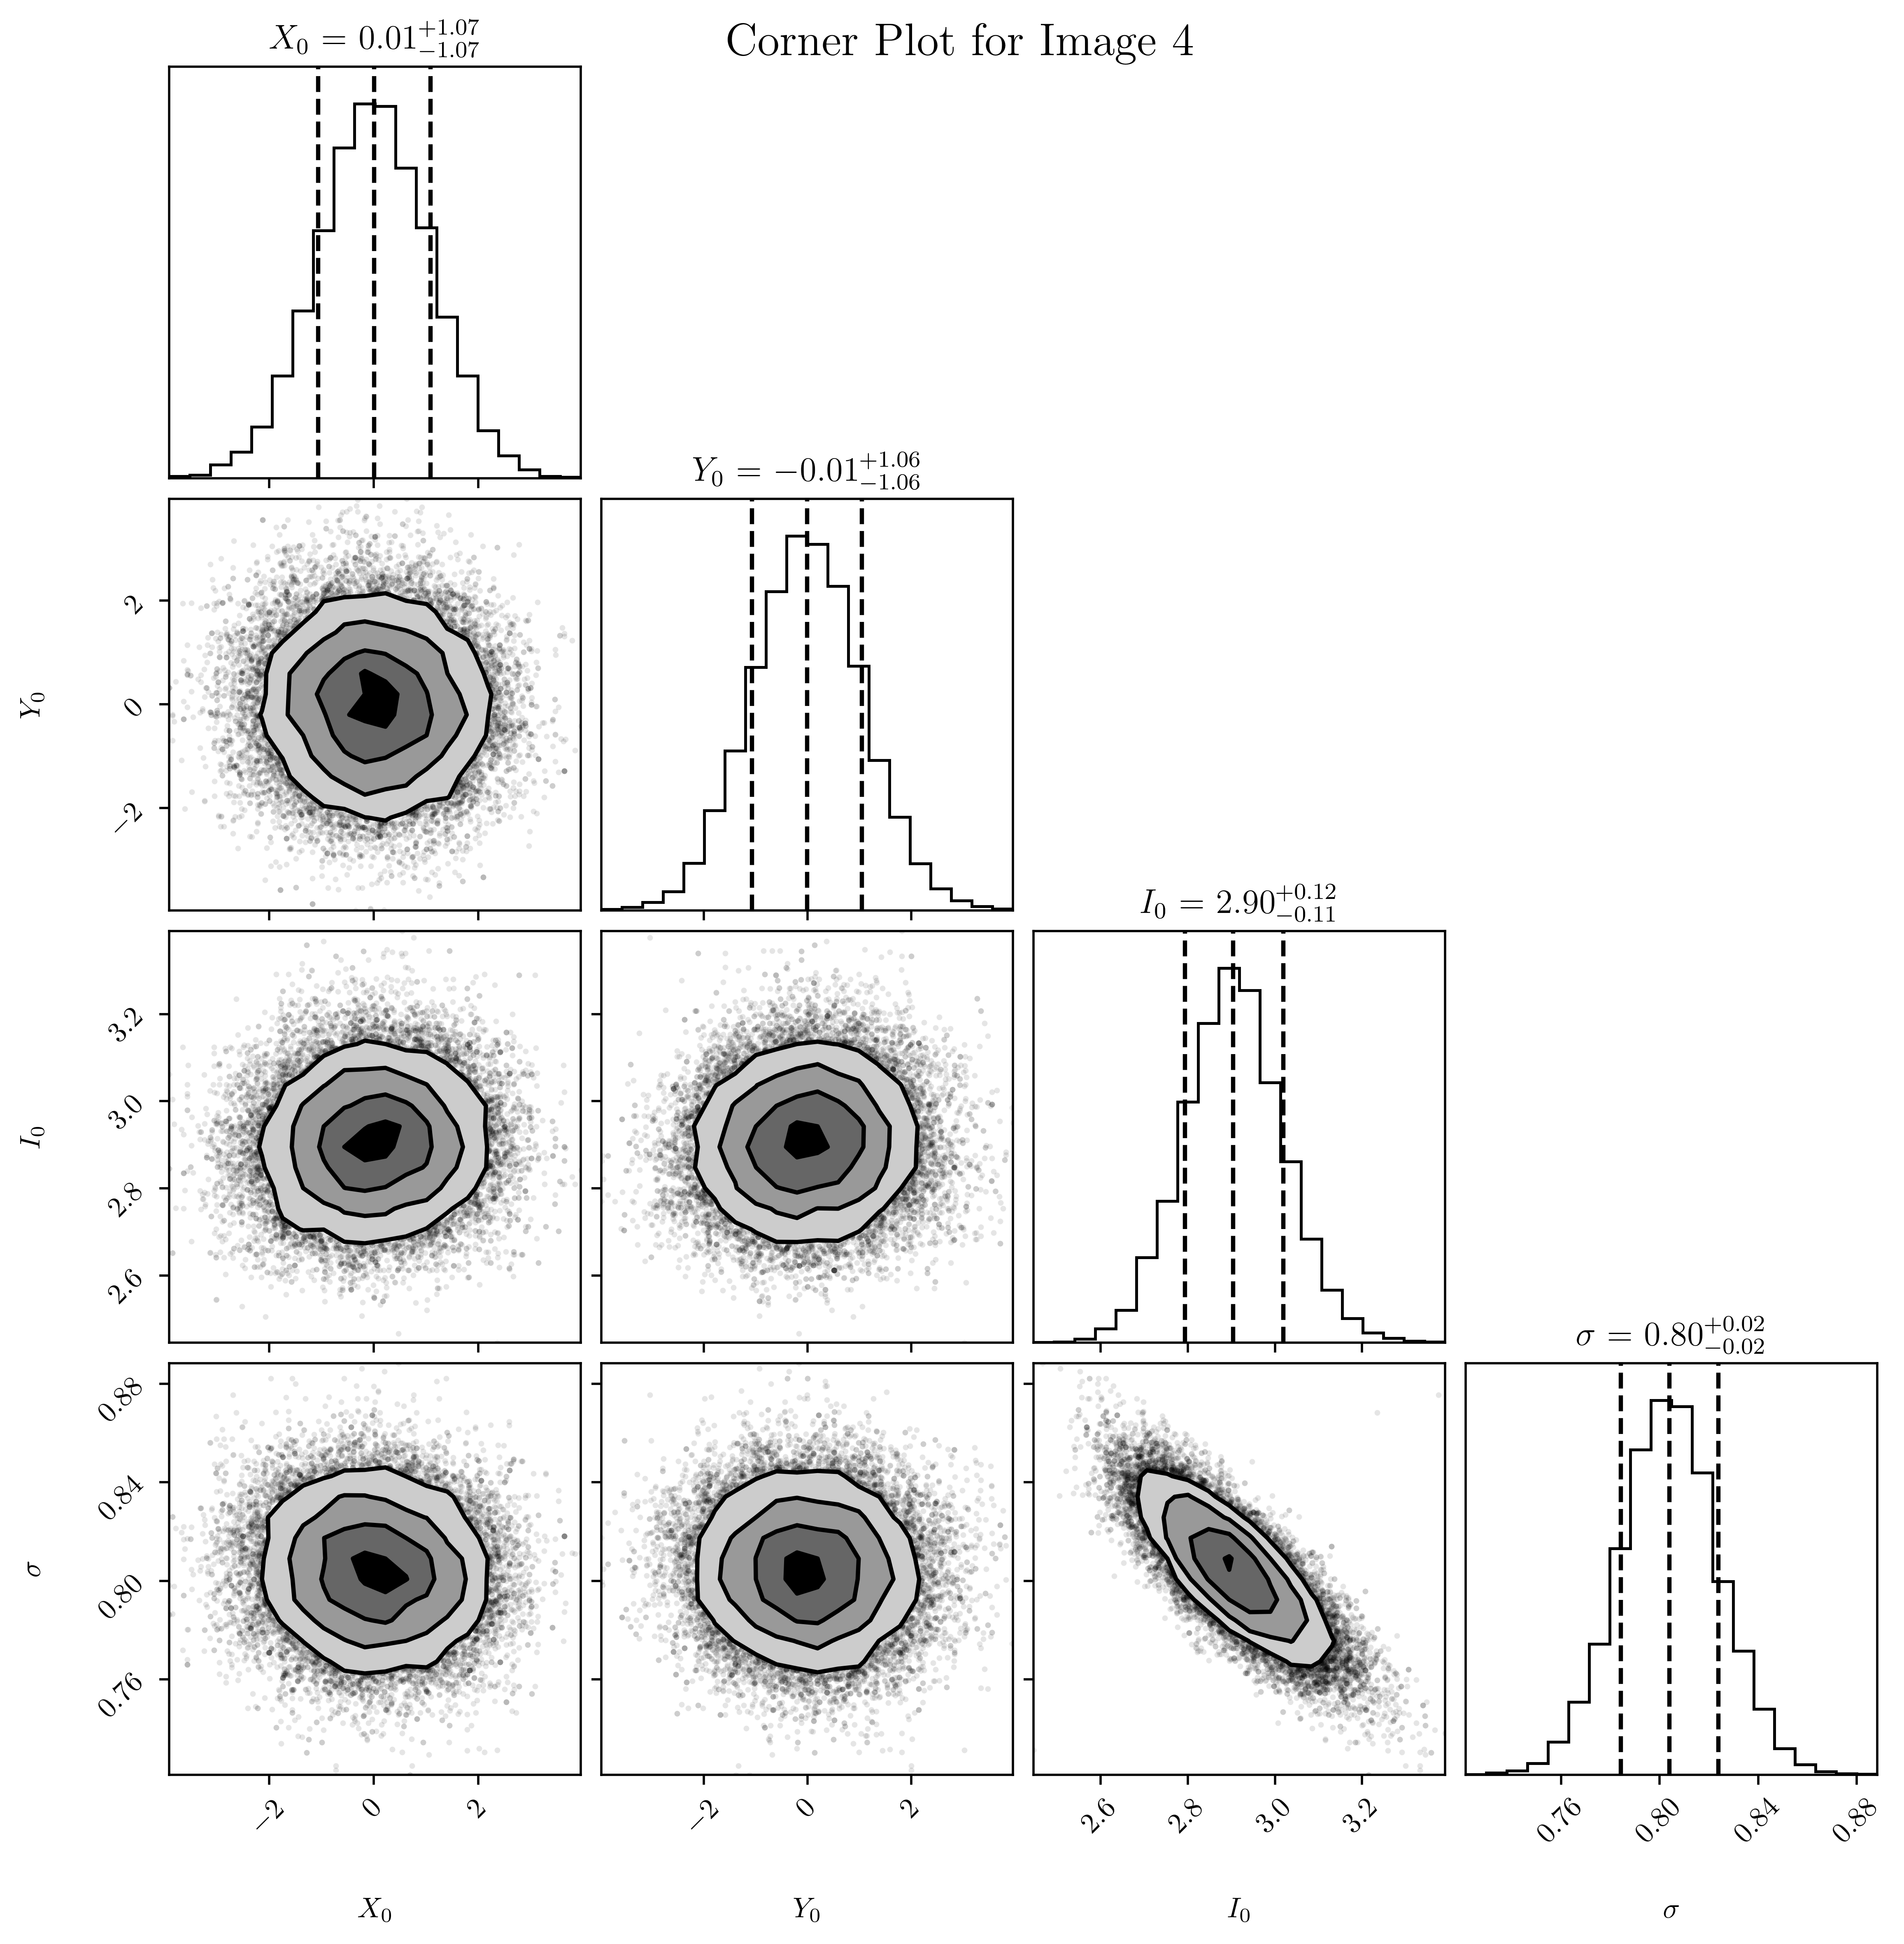

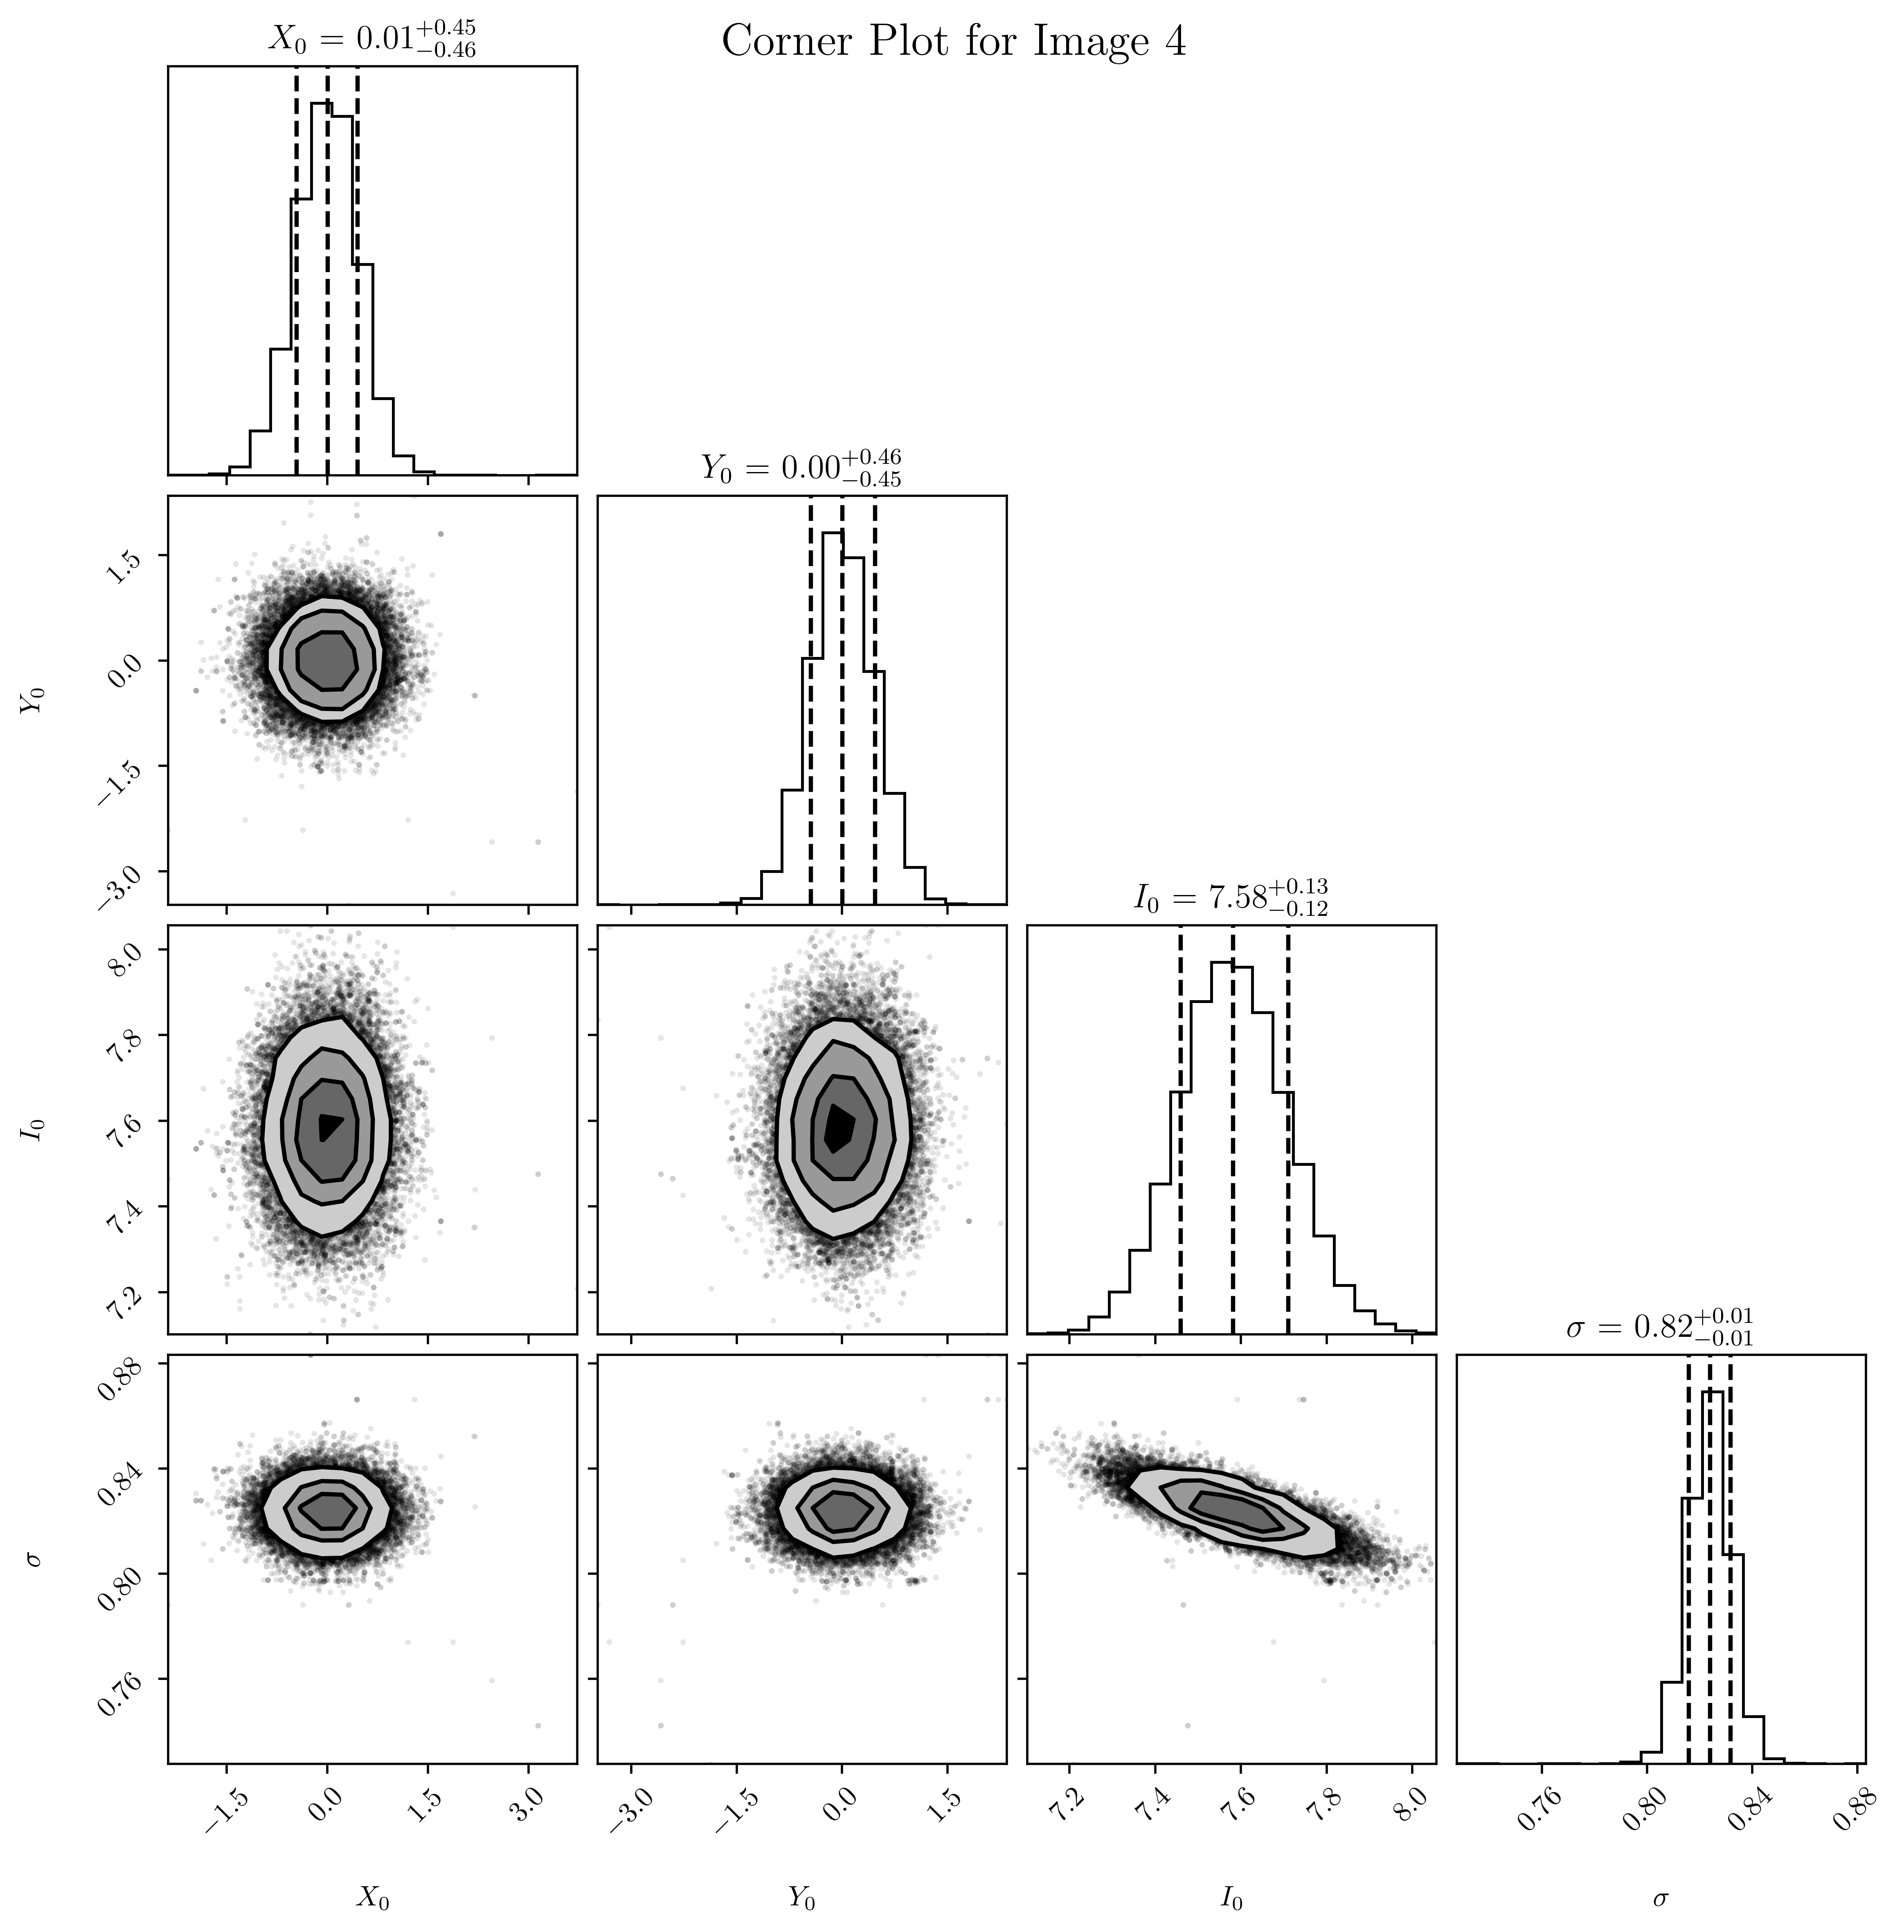

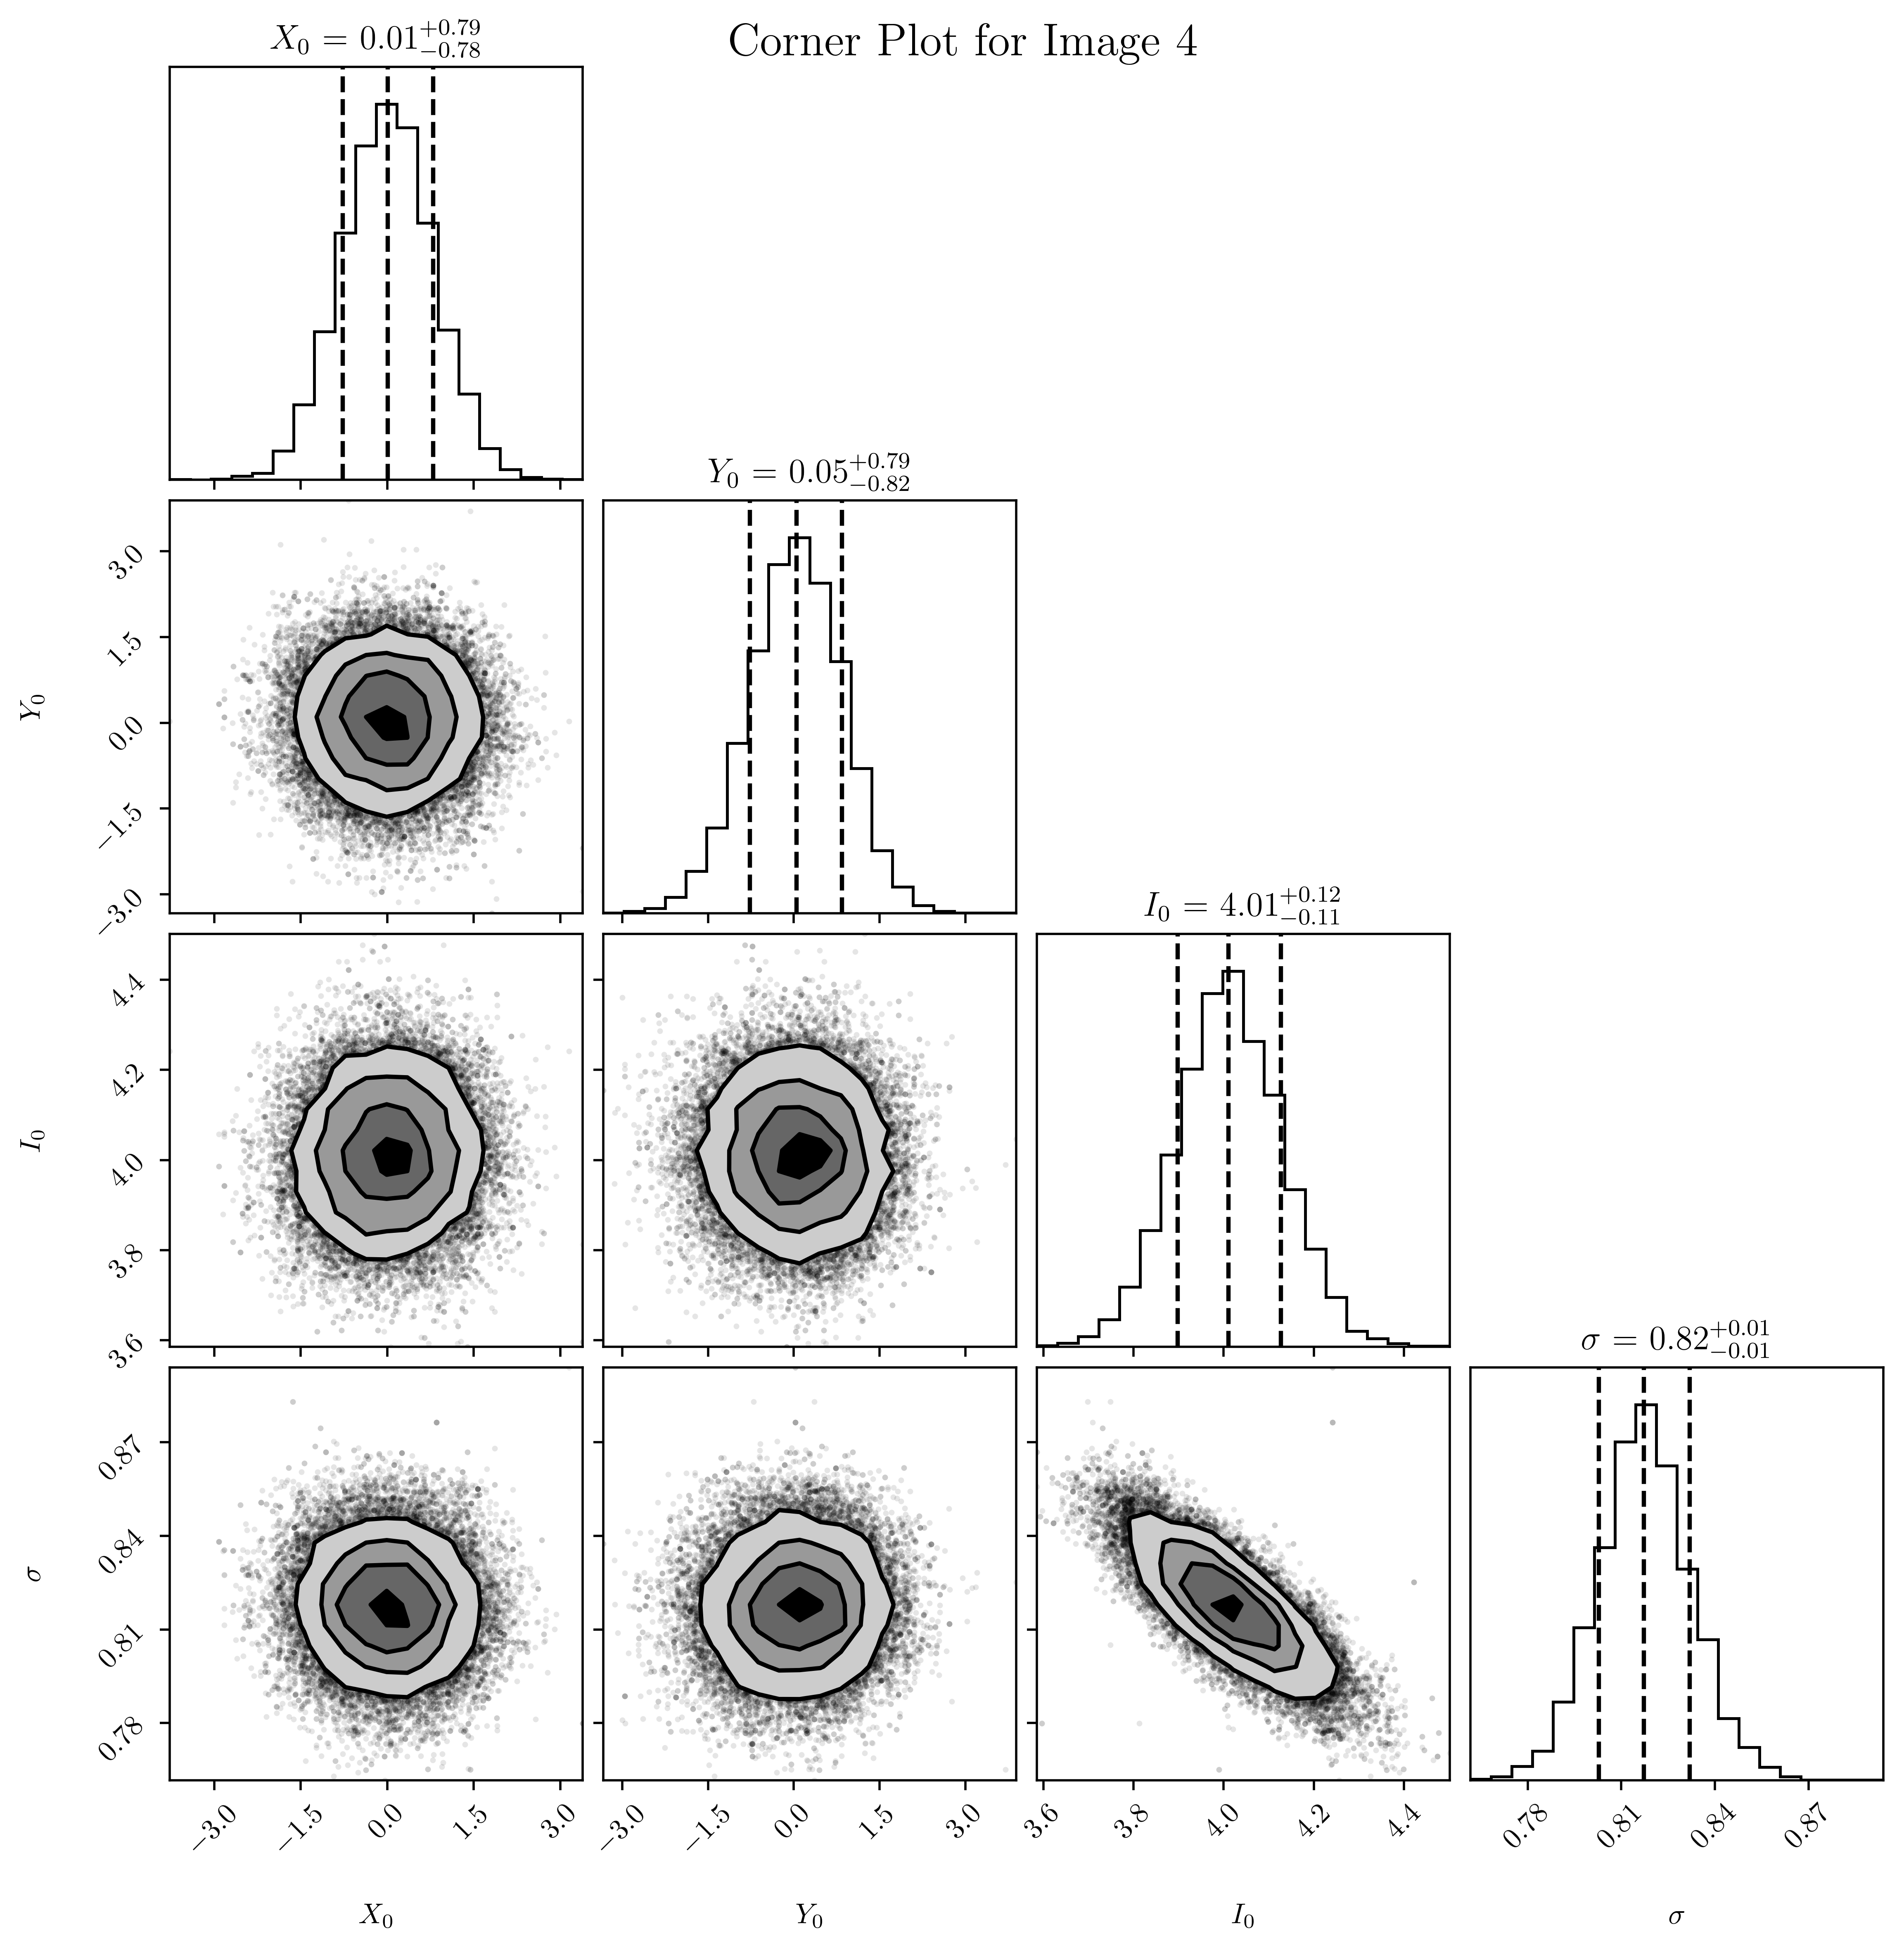

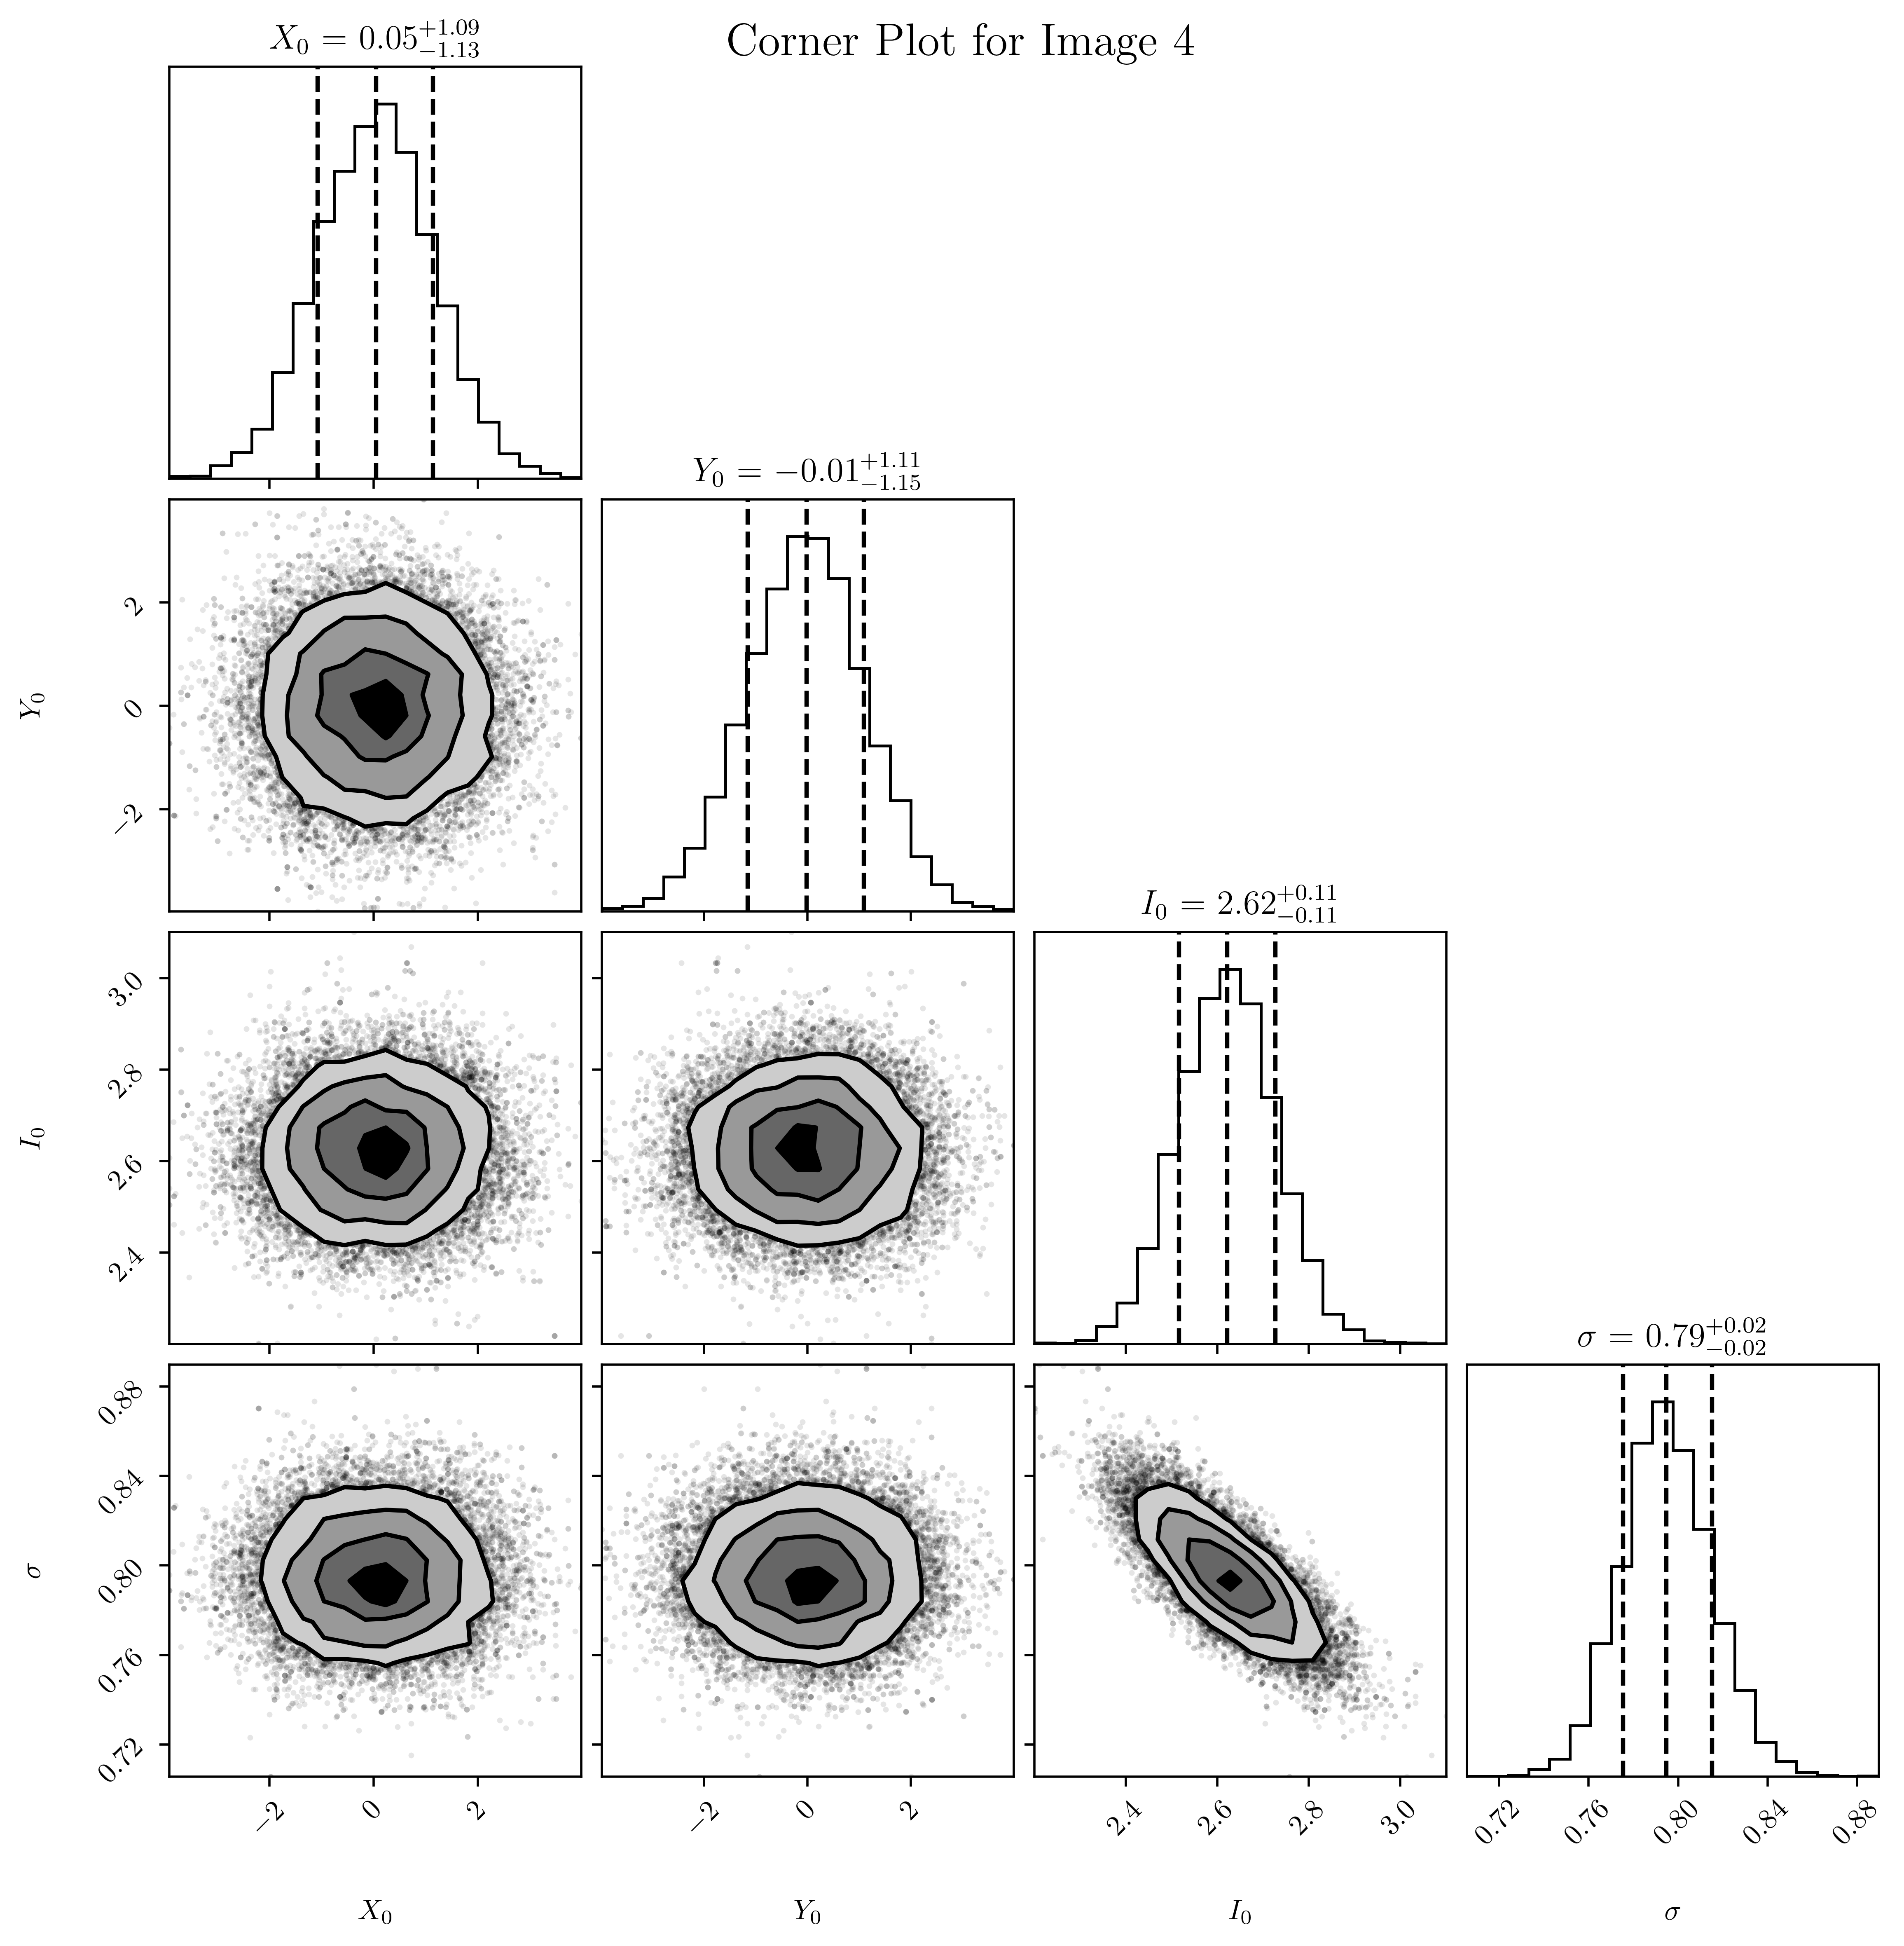

In [31]:
for i in range(len(imgs_x)):
    imfit_Bestfit_Path = folder4imfitfiles+'/imfit_ImgPos/'+'Pos_Img_'+str(i+1)+'_result.txt'
    imfit_Bestfit = pd.read_csv(imfit_Bestfit_Path,comment='#',header=None,sep='\t')
    bestfit_X0 = imfit_Bestfit[2][0]
    bestfit_Y0 = imfit_Bestfit[2][1]
    
    file_name = 'mcmc_result_img_'+str(i+1)+'_chain' # imfit output chain's file name
    mcmc_path = folder4imfitfiles+'/imfit_ImgPos/' # path to the folder containing the mcmc chain files
    Combine_MCMC_Chain(file_name,mcmc_path)
    data = pd.read_csv(mcmc_path+file_name+'.txt',sep='\s+')
    accpetance_rate = (data[data['accept']==1]).shape[0]/data.shape[0] * 100
    print('accpetance rate = '+ str(np.round(accpetance_rate,2)) + '%')
    data = data[data['accept']==1]
    data = data.drop(columns=['likelihood','burn-in','CR1','CR2','CR3','accept',
                             'PA_1','ell_1'])
    data['X0_1'] = (data['X0_1']-bestfit_X0) * 0.04 * 1000
    data['Y0_1'] = (data['Y0_1']-bestfit_Y0) * 0.04 * 1000
    data.to_numpy()

    labels = ['$X_0$','$Y_0$','$I_0$','$\sigma$']
    # Plot it.
    figure = corner.corner(
        data,
        quantiles=[0.16, 0.5, 0.84],
        labels=labels,
        show_titles=True,
        plot_density=True,
        plot_contours=True,
        fill_contours=True,
        color='black',
    )
    figure.suptitle("Corner Plot for Image 4", fontsize=16)

In [32]:
# Positions from MCMC 
mcmc = pd.DataFrame(columns=['X0','Y0','I_0','sigma'])

for i in range(len(imgs_x)):
    imfit_Bestfit_Path = folder4imfitfiles+'/imfit_ImgPos/'+'Pos_Img_'+str(i+1)+'_result.txt'
    imfit_Bestfit = pd.read_csv(imfit_Bestfit_Path, comment='#', header=None, sep='\t')
    bestfit_X0 = imfit_Bestfit[2][0]
    bestfit_Y0 = imfit_Bestfit[2][1]
    
    file_name = 'mcmc_result_img_'+str(i+1)+'_chain' # imfit output chain's file name
    mcmc_path = folder4imfitfiles+'/imfit_ImgPos/' # path to the folder containing the mcmc chain files
    Combine_MCMC_Chain(file_name, mcmc_path)
    data = pd.read_csv(mcmc_path+file_name+'.txt', sep='\s+')
    accpetance_rate = (data[data['accept'] == 1]).shape[0] / data.shape[0] * 100
    print('accpetance rate = '+ str(np.round(accpetance_rate,2)) + '%')
    data = data[data['accept'] == 1]
    data = data.drop(columns=['likelihood', 'burn-in', 'CR1', 'CR2', 'CR3', 'accept', 'PA_1', 'ell_1'])
    data['X'] = data['X0_1'] 
    data['Y'] = data['Y0_1']
    data['X0_1'] = (data['X0_1'] - bestfit_X0) * 0.04 * 1000
    data['Y0_1'] = (data['Y0_1'] - bestfit_Y0) * 0.04 * 1000
    data.to_numpy()
    
    mcmc = pd.concat([mcmc, pd.DataFrame({
        'X' : [data['X'].median()],
        'Y' : [data['Y'].median()],
        'X0': [data['X0_1'].median()],
        'Y0': [data['Y0_1'].median()],
        'I_0': [data['I_0_1'].median()],
        'sigma': [data['sigma_1'].median()],
        'X_0_err_pos': [data['X0_1'].quantile(0.84) - data['X0_1'].median()],
        'Y_0_err_pos': [data['Y0_1'].quantile(0.84) - data['Y0_1'].median()],
        'I_0_err_pos': [data['I_0_1'].quantile(0.84) - data['I_0_1'].median()],
        'sigma_err_pos': [data['sigma_1'].quantile(0.84) - data['sigma_1'].median()],
        'X_0_err_neg': [data['X0_1'].median() - data['X0_1'].quantile(0.16)],
        'Y_0_err_neg': [data['Y0_1'].median() - data['Y0_1'].quantile(0.16)],
        'I_0_err_neg': [data['I_0_1'].median() - data['I_0_1'].quantile(0.16)],
        'sigma_err_neg': [data['sigma_1'].median() - data['sigma_1'].quantile(0.16)]
    })], ignore_index=True)

mcmc = mcmc

mcmc['X0_err'] = np.maximum(mcmc['X_0_err_pos'], mcmc['X_0_err_neg'])
mcmc['Y0_err'] = np.maximum(mcmc['Y_0_err_pos'], mcmc['Y_0_err_neg'])
mcmc['I_0_err'] = np.maximum(mcmc['I_0_err_pos'], mcmc['I_0_err_neg'])
mcmc['sigma_err'] = np.maximum(mcmc['sigma_err_pos'], mcmc['sigma_err_neg'])

mcmc = mcmc.drop(columns=['X_0_err_pos', 'Y_0_err_pos', 'I_0_err_pos', 'sigma_err_pos', 'X_0_err_neg', 'Y_0_err_neg', 'I_0_err_neg', 'sigma_err_neg'])

accpetance rate = 33.98%
accpetance rate = 35.93%
accpetance rate = 35.53%
accpetance rate = 35.73%


In [33]:
mcmc['X_arcsec'] = mcmc['X'] * 0.04
mcmc['Y_arcsec'] = mcmc['Y'] * 0.04

In [146]:
# Old Gaussian Integration

# def gaussian(x, y, amp, x0, y0, sigma):
#     return amp * np.exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))


# mcmc['flux'] = np.nan

# for i in range(len(mcmc)):
#     amp = mcmc['I_0'][i]
#     x0 = mcmc['X0'][i]
#     y0 = mcmc['Y0'][i]
#     sigma = mcmc['sigma'][i]
#     integral, error = dblquad(gaussian, -np.inf, np.inf, lambda x: -np.inf, lambda x: np.inf, args=(amp, x0, y0, sigma))
#     mcmc['flux'][i] = integral

# mcmc['flux_ratio'] = mcmc['flux'] / mcmc['flux'].max()
# mcmc['flux_ratio'] = mcmc['flux_ratio']

In [34]:
data = fits.open('/Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input/System_4/Rom_elli_bad.fits')
data.info()
M = data[0].header['HIERARCH Source Absolute AB Magnitude']
z = data[0].header['Z_SOURCE']
PHOTFLAM = data[0].header['PHOTFLAM']
WL_PIVOT=  data[0].header['WL_PIVOT']

def flux2mag(M, z, flux):
    
    # Zero Point
    f_PHOTZPT = 2.49767E-9 #erg/cm**2/s/AA, filter: SDSS-r
    f0_PHOTZPT = f_PHOTZPT * (1E-3) * WL_PIVOT
    PHOTZPT = (2.5)*np.log10(f0_PHOTZPT)
    
    # Prdicted SNIa apparent magnitude (from luminosity distance relation)
    Dls = (cosmo.luminosity_distance(z)).value*np.power(10,6) 
    ms = M + 5*np.log10(Dls/10)
    
    # Apparent magnitude from flux
    flux0 = flux*PHOTFLAM*WL_PIVOT #erg/cm**2/s
    f = flux0*(1E-3) #joules/m**2/s
    m = -(2.5)*np.log10(f) + PHOTZPT
    
    # Magnitude difference to magnification
    m_diff = m-ms
    base = np.power(10, 1/2.5)
    mag = 1/np.power(base,abs(m_diff))
    
    return mag

Filename: /Users/ainsleylewis/Documents/Astronomy/HPC/Lensing/Simulations/Input/System_4/Rom_elli_bad.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   (553, 553, 6)   float64   


In [35]:
# New Gaussian Integration
def integrated_light(int_peak, sigma):
    C = 2*np.pi*(1-np.exp(-4.5))
    F = C * int_peak * (sigma**2)
    return F

mcmc['flux'] = np.nan
err_flux_mcmc = []
for i in range(len(mcmc)):
    file_name = 'mcmc_result_img_'+str(i+1)+'_chain' # imfit output chain's file name
    mcmc_path = folder4imfitfiles+'/imfit_ImgPos/' # path to the folder containing the mcmc chain files
    Combine_MCMC_Chain(file_name,mcmc_path)
    data = pd.read_csv(mcmc_path+file_name+'.txt',sep='\s+')
    data = data[data['accept']==1]
    intensity = np.array(data['I_0_1'])
    sigma = np.array(data['sigma_1'])
    flux = integrated_light(intensity, sigma)
    mcmc['flux'][i] = np.median(flux)
    flux_err = np.std(flux)
    err_flux_mcmc.append(flux_err)

err_flux_mcmc = np.array(err_flux_mcmc)[[0,2,3,1]]
print(err_flux_mcmc)
mcmc['flux_err'] = err_flux_mcmc
err_mag_mcmc = flux2mag(M, z, err_flux_mcmc)
print(err_mag_mcmc)
mcmc['mag_err'] = err_mag_mcmc

[0.36270245 0.37733861 0.33249102 0.41944076]
[0.15316792 0.15934872 0.14040974 0.1771283 ]


In [36]:
flux = np.array(mcmc['flux'])

mag = 1/np.round(flux2mag(M, z, flux),3)

max_flux = np.max(flux)
flux_ratio = flux/max_flux

max_mag = np.max(mag)
mag_ratio = mag/max_mag

mcmc['mag'] = mag
mcmc['mag_ratio'] = mag_ratio

In [37]:
mcmc

X0        Y0       I_0     sigma           X           Y    X0_err  \
0  0.008624 -0.007724  2.903910  0.803918  271.785916  265.860207  1.073536   
1  0.006152  0.003348  7.581671  0.823943  285.447154  269.633884  0.464636   
2  0.009568  0.050144  4.010973  0.817287  287.783939  281.050454  0.787312   
3  0.049696 -0.014180  2.621860  0.794678  268.023242  286.081546  1.125499   

     Y0_err   I_0_err  sigma_err   X_arcsec   Y_arcsec       flux  flux_err  \
0  1.061148  0.115251   0.019967  10.871437  10.634408  11.659973  0.362702   
1  0.464304  0.129153   0.008088  11.417886  10.785355  31.978625  0.377339   
2  0.818156  0.116455   0.014668  11.511358  11.242018  16.655126  0.332491   
3  1.145529  0.105205   0.020604  10.720930  11.443262  10.286231  0.419441   

    mag_err        mag  mag_ratio  
0  0.153168   4.926108   0.364532  
1  0.159349  13.513514   1.000000  
2  0.140410   7.042254   0.521127  
3  0.177128   4.347826   0.321739

In [38]:
final_table = mcmc[['X_arcsec', 'Y_arcsec', 'X0_err', 'Y0_err', 'flux', 'flux_err', 'mag', 'mag_err']]
final_table = final_table.rename(columns={'X0_err': 'X_err_mac', 'Y0_err': 'Y_err_mac'})
final_table

X_arcsec   Y_arcsec  X_err_mac  Y_err_mac       flux  flux_err        mag  \
0  10.871437  10.634408   1.073536   1.061148  11.659973  0.362702   4.926108   
1  11.417886  10.785355   0.464636   0.464304  31.978625  0.377339  13.513514   
2  11.511358  11.242018   0.787312   0.818156  16.655126  0.332491   7.042254   
3  10.720930  11.443262   1.125499   1.145529  10.286231  0.419441   4.347826   

    mag_err  
0  0.153168  
1  0.159349  
2  0.140410  
3  0.177128

In [39]:
final_table.to_csv(main_folder_path+sub_folder_path+'/results.dat', index=False, sep='\t')